<a href="https://colab.research.google.com/github/LorenzoLamberti94/APAI2021/blob/main/Solution_LAB1_APAI_DNN_Definition_%26_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LAB1 APAI: DNN Definition & Training**

**Credits**: *Lorenzo Lamberti, Francesco Conti,  Alessio Burrello, Nazareno Bruschi, Davide Nadalini, Alberto Dequino.*
*(University of Bologna)*

**Contacts**: *lorenzo.lamberti@unibo.it*, *f.conti@unibo.it* 



## **In this Hands-on session:**

A first-time user of Pytorch framework will learn how to define, train, and test a neural network over the Fashion-MNIST dataset.

### Tasks:

---

1.  PyTorch definition of a NN model;
2. Calculate MAC and kB of the Neural model defined;
3. Data loader for Fashion-MNIST
4. Code for testing a neural network on Fashion MNIST dataset;
5. Code for training a neural network on Fashion MNIST;
6. Save and load model’s trained weights;
7. Bonus: reduce network’s size under 5MMAC 
---




## Let's start !

Let us start by installing dependencies...

In [57]:
#@title Install dependencies { form-width: "20%" }

# these ones should already be available
!pip install numpy
!pip install tqdm
!pip install pillow

!pip install torch
!pip install torchvision

!pip install thop
!pip install matplotlib
!pip install sklearn
!pip install torchinfo

# You will need these if running on a private server (no colab)
# !pip install jupyter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension



## Imports:
Now we import some packages  we will need:

In [58]:
#basic
import os
from os.path import join
import numpy as np
from tqdm import tqdm
import time

#plotting
import matplotlib.pyplot as plt

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#torchvision
import torchvision
from torchvision import transforms, datasets

# others
from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect



PyTorch version in use: 1.10.0+cu111 
cuda avail:  True


## Set device
Between "cuda" and "cpu"

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


# **Task 1:** Creating a Model
---



The first real step is to define the network topology. We will define a custom one.

* Use `torch.nn.Module`,
* **IMPORTANT:** Instantiate a separate `torch.nn.Module` for each node in your topology; This is mandatory for parametric modules (e.g., `torch.nn.Conv2d`, `nn.Linear`,`nn.BatchNorm2d`).

---

You can use the following modules:
* `nn.Conv2d`
* `nn.Linear`
* `nn.BatchNorm2d`
* `nn.ReLU`
* `nn.MaxPool2d`
* `nn.LogSoftmax`



**You must define the NN topology following this diagram:**

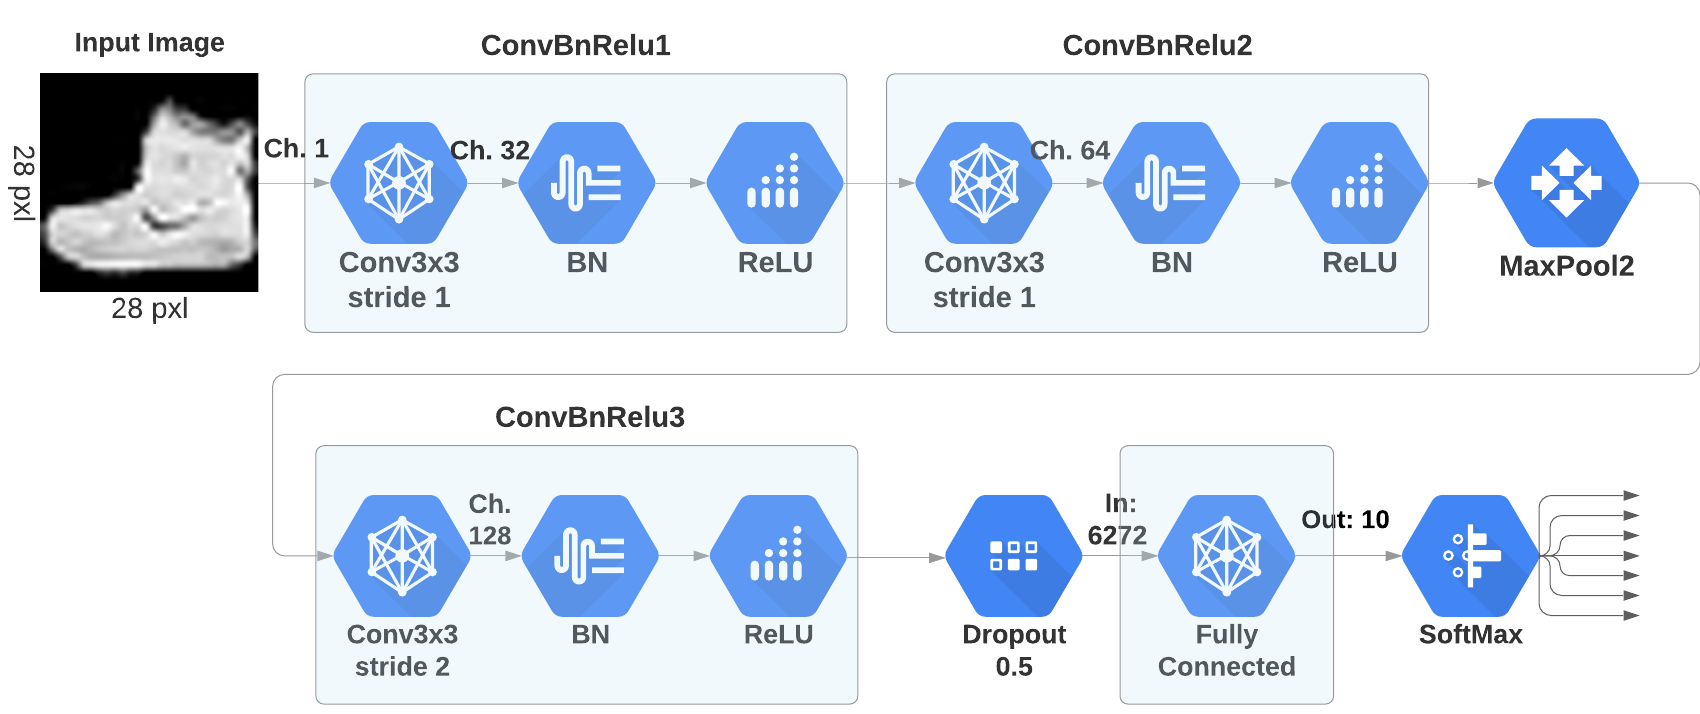

### This is how our network looks like:

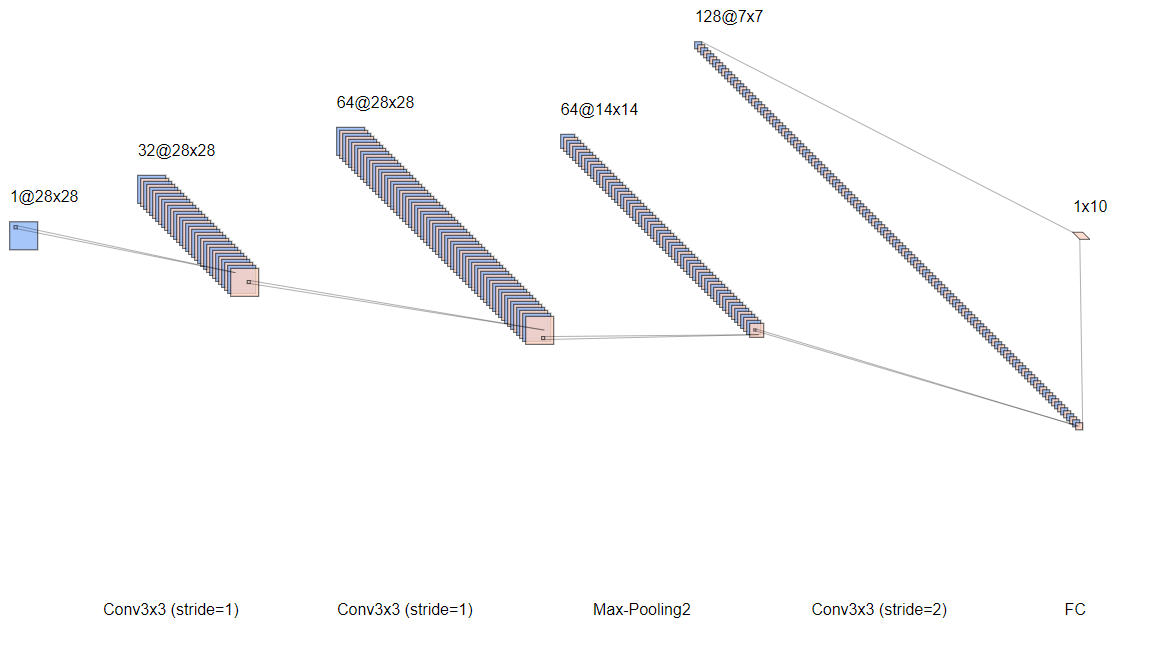

In [60]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBnRelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

class CNN(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN, self).__init__()
        # first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, 32,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(32, 64,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(64, 128, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*128
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.fc(x)
        output = self.softmax(x)
        return output

net = CNN().to(device)


### Test defined network, and verify layers




In [61]:
#@title Dummy input  { form-width: "70%" }
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (1, 1, 28, 28)  #@param
input = torch.randn(input_size).to(device)#add one extra field to input size for batch_n


Print output tensor size and the CNN network topology defined:

In [62]:
output = net(input)
print('Output shape:', output.shape)
print('Network Topology:\n',net)

Output shape: torch.Size([1, 10])
Network Topology:
 CNN(
  (ConvBnRelu1): ConvBnRelu(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
  )
  (ConvBnRelu2): ConvBnRelu(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvBnRelu3): ConvBnRelu(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=6272, out_features=10, bias=False)
  (softmax): LogSoftmax(dim=1)
)


# **Task 2:** Count network's parameters and MAC operations

---

Let's define a couple of useful functions to measure the model's MAC operations and number of parameters.
These two functions are equivalent !

In [63]:
def network_size_and_mac(net, input_size, verbose=False):
    from thop import profile
    if verbose: print('input_size is now:', input_size)
    input = torch.randn(input_size).to(device) # initialize a random tensor
    macs, params = profile(net, inputs=(input, ), verbose=verbose) #toggle verbose to True to debug errors
    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

def print_summary(net, input_size):
    from torchinfo import summary
    print(summary(net, input_size=input_size))

network_size_and_mac(deepcopy(net), input_size) #use deepcopy to avoid graph modifications by hese function calls
print_summary(deepcopy(net), input_size) #use deepcopy to avoid graph modifications by hese function calls

Network's 	n°params: 155.616k 	MAC: 18.515M

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─ConvBnRelu: 1-1                        [1, 32, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           288
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─ReLU: 2-3                         [1, 32, 28, 28]           --
├─ConvBnRelu: 1-2                        [1, 64, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 64, 28, 28]           18,432
│    └─BatchNorm2d: 2-5                  [1, 64, 28, 28]           128
│    └─ReLU: 2-6                         [1, 64, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 64, 14, 14]           --
├─ConvBnRelu: 1-4                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-7                       [1, 128, 7, 7]            73,728
│    └─BatchNorm2d: 2-8       

**TorchInfo insights:**
This tool calculates the Parameters Size as (number_of_parameters*4).
This because each parameter needs 4 Bytes (32bit) to be represented in float32 format.

# **Task 3:** Dataset & DataLoaders

---

In this notebook we'll a custom CNN on the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), which is a set of 28x28 grayscale images of clothes.
This dataset is provided by the [Torchvision package](https://pytorch.org/docs/stable/torchvision/index.html).

Before diving in, let's look at the Fashion MNIST dataset. The dataset has 6k training images and 1k validation images. It has a total of 10 classes, each represented by an integer index. The following cell creates a mapping from these indices to their corresponding human-readable strings, then downloads the Fashion MNIST training dataset from Torchvision. It may take a minute to run.

Torchvision provides easy access to many datasets, including COCO, CIFAR, and Cityscapes. See its documentation for a complete list. 

The dataset is stored on the Colab VM in the `/data/fashionmnist` directory.

*You can explore dataset images by changing the index below:*

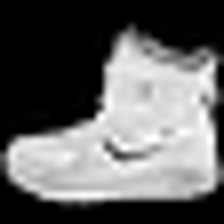

ankle boot


In [64]:
#@title Show dataset image samples
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
path='./data/fashionmnist'
fashion_mnist_dataset = datasets.FashionMNIST(
    path,
    train=True,
    download=True)

img_index = 0 #@param {type:"integer"}

tup = fashion_mnist_dataset[img_index] # tup = (image, label)
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

### Data loaders for Fashion MNIST



The code below first sets up transform using `torhvision transfroms` for converting images to pytorch tensors and normalizing the images.

Next, We use `torchvision datasets` for dowloading the fashion mnist dataset and applying transforms which we defined above.

* `train_dataset` contains the training data.
* `valid_dataset` contains the validation data

Next, We use `pytorch dataloader` for making dataloader from the train and validation sets.

In [65]:
def get_data_loaders(train_batch_size=128, val_batch_size=128, path='./data/fashionmnist',verbose=False):
    #define data transformations
    fashion_mnist = datasets.FashionMNIST(download=True, train=True, root=path).train_data.float()
    data_transform = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])
    
    # Load train/valid datasets
    train_dataset = datasets.FashionMNIST(download=False, root=path, transform=data_transform, train=True)
    valid_dataset = datasets.FashionMNIST(download=False, root=path, transform=data_transform, train=False)

    # define dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=train_batch_size, 
        shuffle=True)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=val_batch_size, 
        shuffle=False)

    # count how many images we have in each set
    train_dataset_size = len(train_dataset)
    valid_dataset_size = len(valid_dataset)
    if verbose: print('Dataset size:\nTraining images %d,\nValidation images %d' % (train_dataset_size, valid_dataset_size))
    
    return train_loader, valid_loader

train_loader, val_loader = get_data_loaders( verbose=True)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Dataset size:
Training images 60000,
Validation images 10000


#**Task 4:** testing the CNN over the dataset

---



### Accuracy Metric calculation

First we define a function to calculate the accuracy, defined as: `accuracy = num_correct_predictions/total_n_predictions`



In [66]:
def calculate_accuracy(best_guesses, targets):
    num_correct = torch.eq(targets, best_guesses).sum().item()
    total_guesses = len(targets)
    correct_percentage = num_correct/total_guesses
    return correct_percentage

Or you could take advantage of scikitlearn to calcultate the Accuracy! (we wont use it in this tutorial, but it would be a ready-to-use function!)

In [67]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    

### Testing Function
Before training we want to verify our data->network pipeline and set a baseline level of performance. The following cell defines a function, `validate,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified.

In [68]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []
    
    # set net to evaluating (testing)
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # net forward
            outputs = net(inputs) # this gets the prediction from the network

            # calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss) # append current average training loss to a buffer variable, for plotting learning curve

            # calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu())) 
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) #this is the same accuracy calculated with scikitlearn
            
    average_val_loss = sum(val_losses)/(batch_idx+1)
    return val_accuracy, average_val_loss
    

You should see the untrained network guess about 10% of the dataset correctly, since it's randomly guessing and there are 10 classes.

In [69]:
loss_function = nn.CrossEntropyLoss() # cross entropy works well for multi-class problems

val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

Accuracy: 0.09


# **Task 5:** Training Loop

---



**Basic training in PyTorch:**
- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- use `net.zero_grad()` to reset the gradients before backpropagation.
- calls `backward()` on the loss to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights

In this case we'll use: 
* **Loss Function:** [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) since we have a classification problem.
* **Optimizer:** We'll use the [Adam](https://pytorch.org/docs/master/optim.html#torch.optim.Adam) optimizer since it's a very easy optimizer to use (no need to tweak hyperparameters).

**Loops:** 

*   for loop over `epochs`: at the end of each epoch we calculate the validation accuracy
*   for loop over `training batches`: for each batch we backpropagate using the loss function




- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- use `net.zero_grad()` to reset the gradients before backpropagation.
- calls `backward()` on the loss to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights
```
Pseudo-code:
├─ for each epoch (enumerate):
│  ├── for each training batch:
│  │  ├── output = net(input)
│  │  ├── loss = (output,ground_truth)
│  │  ├── net.zero_grad()
│  │  ├── loss.backward()
│  │  ├── optimizer step()
│  │  ├── calculate training accuracy
│  │  └── print: training accuracy and loss
│  └── test on validation set: print accuracy


We'll only train for 5 epochs for timeliness. The following cell should take 4-5 minutes to run.

### **Note: why do we need to reset the gradients**
In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero (`net.zero_grads()`)before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. So, the default action has been set to accumulate (i.e. sum) the gradients on every `loss.backward()` call.

I f you don't reset them, the gradient would be a combination of the old gradient, which you have already used to update your model parameters, and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

In [70]:
#@title Training parameters { form-width: "70%" }
epochs = 5 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

In [71]:
# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# Define loss function
loss_function = nn.CrossEntropyLoss() # cross entropy works well for multi-class problems


def training(net, train_loader, val_loader, loss_function, epochs):    
    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

    # count tot batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    # Create lists to store training history
    train_loss_history = []
    train_accuracy_history = []
    # Create lists to store validation history
    val_loss_history = []
    val_accuracy_history = []

    start_ts = time.time()
    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=tot_train_batches)

        # ----------------- TRAINING  -------------------- #
        # set model to training
        net.train()
        
        for batch_idx, data in progress:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Compute prediction (forward input in the model)
            outputs = net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # Backpropagation
            net.zero_grad()
            loss.backward()
            # Optimizer step
            optimizer.step()

            # getting training quality data
            current_loss = loss.item()

            #compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss/(batch_idx+1)
            
            # calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            train_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu()))
            average_train_accuracy = sum(train_accuracy)/(batch_idx+1)

            # updating progress bar
            progress.set_description("Training Loss: {:.4f}, Accuracy: {:.4f}".format(average_train_loss, average_train_accuracy))
            
            ## DEBUG: stop after one single batch
            # break

        # ----------------- VALIDATION  ----------------- #
        val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
        
        # compute mean accuracy
        average_train_accuracy = sum(train_accuracy)/tot_train_batches
        average_val_accuracy = sum(val_accuracy)/tot_val_batches

        # print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch+1,epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))
        
        # append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(average_train_loss)
        val_loss_history.append(average_val_loss)
        train_accuracy_history.append(average_train_accuracy)
        val_accuracy_history.append(average_val_accuracy)

    print('Training time: %.1f seconds' % (time.time()-start_ts))

            
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [72]:
(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, epochs)

Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 Training loss:  0.4208 Accuracy: 0.8503
Validation Loss: 0.2975 Accuracy: 0.8925


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 Training loss:  0.2813 Accuracy: 0.8979
Validation Loss: 0.2651 Accuracy: 0.9052


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 Training loss:  0.2454 Accuracy: 0.9124
Validation Loss: 0.2460 Accuracy: 0.9102


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 Training loss:  0.2243 Accuracy: 0.9195
Validation Loss: 0.2454 Accuracy: 0.9103


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 Training loss:  0.2075 Accuracy: 0.9252
Validation Loss: 0.2349 Accuracy: 0.9129
Training time: 159.0 seconds


We now re-evaluated our network's performance, and you will see an accuracy ~90%

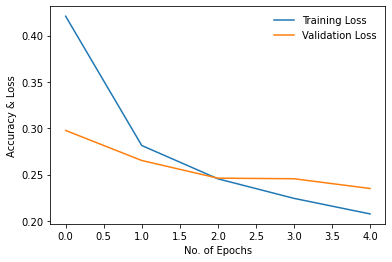

In [73]:
plt.plot(train_loss_history,label="Training Loss")
plt.plot(val_loss_history,label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy & Loss')
plt.legend(frameon=False)
plt.show()

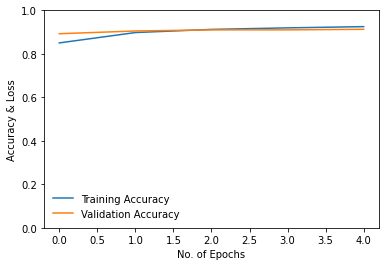

In [74]:

plt.plot(train_accuracy_history,label="Training Accuracy")
plt.plot(val_accuracy_history,label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy & Loss')
plt.ylim([0., 1.]) # limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()

# **Task 6:** Save/Load Model

---



In [75]:
#@title Training parameters { form-width: "70%" }
model_export_path = "./model/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}
os.makedirs(model_export_path, exist_ok=True)


### Save a PyTorch Model

In [76]:
#Save Pytorch model
torch.save(net.state_dict(), join(model_export_path,model_name))    


### Load a PyTorch Model

In [77]:
# Load a PyTorch Model
NEW_net = CNN().to(device)
state_dict = torch.load(join(model_export_path,model_name))
NEW_net.load_state_dict(state_dict)

<All keys matched successfully>

Test again the network accuracy, to be sure that you saved/loaded weights correctly

In [78]:
# Test over validation dataset
val_accuracy, average_val_loss = validate(NEW_net, val_loader, loss_function, accuracy_score)
# Print valid statistics
average_val_accuracy = sum(val_accuracy)/len(val_loader)
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

Validation Loss: 0.2349 Accuracy: 0.9129


## Export to ONNX format

The network can be exported in ONNX format for usage in **DORY (*Deplyment Oriented to memoRY*)** or other deployment tools. In the frame below, we export the produced graph to ONNX format. **ONNX (*Open Neural Network eXchange*)** is an interchange format that can be used to deploy the network on an inference engine - including our own DORY (soon to be released for deployment on PULP-based platforms). To see how the model looks like, the cell will trigger a download to your local machine and then open a frame into a tool called **Netron** (https://lutzroeder.github.io/netron) that can be used to visualize it: just drag the ONNX file and drop it on top of the Netron frame!

In [79]:
torch.onnx.export(net, input, 'fmnist_cnn.onnx')
from IPython.display import IFrame
from google.colab import files
import urllib
files.download('fmnist_cnn.onnx')
url = urllib.parse.quote("https://lutzroeder.github.io/netron", safe=':/?=&')
IFrame(url, width=800, height=400)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Task 7:** Reduce Network's MAC operations 

---


Current network has: 
*   n°params: 155.616k
*   MAC: 18.515M

**Task:** Reduce it below 5 MMAC, but keeping accuracy ~90%.

**Solution:**

In this solution we will reduce the number of channels of the convolutional layers, by halving them (depth multiplier = 0.5).

You can explore another 2 ways:
1.   Add or remove layers
2.   Play with the “stride” of che convolutional layers.





## New network with reduced size

In [80]:
class CNN_reduced(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN_reduced, self).__init__()
        first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, first_conv_channels,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(first_conv_channels, first_conv_channels*2,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(first_conv_channels*2, first_conv_channels*4, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7

        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*(first_conv_channels*4)
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.fc(x)
        output = self.softmax(x)
        return output

net_reduced = CNN_reduced(depth_mult=.5).to(device)


Let's see how many MAC operations the new network has...

In [81]:
network_size_and_mac(deepcopy(net_reduced), input_size) #use deepcopy to avoid graph modifications by hese function calls
print_summary(deepcopy(net_reduced), input_size) #use deepcopy to avoid graph modifications by hese function calls

Network's 	n°params: 54.768k 	MAC: 4.742M

Layer (type:depth-idx)                   Output Shape              Param #
CNN_reduced                              --                        --
├─ConvBnRelu: 1-1                        [1, 16, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           144
│    └─BatchNorm2d: 2-2                  [1, 16, 28, 28]           32
│    └─ReLU: 2-3                         [1, 16, 28, 28]           --
├─ConvBnRelu: 1-2                        [1, 32, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 32, 28, 28]           4,608
│    └─BatchNorm2d: 2-5                  [1, 32, 28, 28]           64
│    └─ReLU: 2-6                         [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─ConvBnRelu: 1-4                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 64, 7, 7]             18,432
│    └─BatchNorm2d: 2-8           

**The New network has 4.742M MAC, which is less than our constrain of 5M !!**

## Retrain the network and verify validation accuracy ~90%

In [82]:
(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net_reduced, train_loader, val_loader, loss_function, epochs)

Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5 Training loss:  0.4933 Accuracy: 0.8264
Validation Loss: 0.3396 Accuracy: 0.8800


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5 Training loss:  0.3224 Accuracy: 0.8837
Validation Loss: 0.3033 Accuracy: 0.8890


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5 Training loss:  0.2867 Accuracy: 0.8972
Validation Loss: 0.2713 Accuracy: 0.9013


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5 Training loss:  0.2627 Accuracy: 0.9055
Validation Loss: 0.2823 Accuracy: 0.8976


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5 Training loss:  0.2455 Accuracy: 0.9120
Validation Loss: 0.2485 Accuracy: 0.9098
Training time: 136.7 seconds


# Not used

## Average Meter class (not used right now)

In [83]:
# convenience class to keep track of averages
class AverageMeter(object):
    """
    Computes and stores the average and current value
    Copied from: https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt # format. example ':6.2f'
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)




## **Exercise 1**
.....TEMPLATE
* ...
* ...
* ...

> *Answer:...*